In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb


import warnings
warnings.filterwarnings("ignore")

/home/anson/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Theoretical $q^2$

In [2]:
def dGammaDsmu(q2):
    return 1.08656*10**(-6) * (1 - 0.011025/q2)**2 *np.sqrt((11.5532 - q2) * (53.8022 - q2)) * q2 * (3.10955/(q2**2 * (1 - 0.058671 * q2 + 0.000940087 * q2**2)**2) + (0.3025 * (1 + 0.0055125/q2) * (11.5532 - q2) * (53.8022 - q2))/(q2 * (1 - 0.0847084 * q2 + 0.00204891 * q2**2)**2))

def dGammaDstau(q2):
    return 1.08656*10**(-6) * (1 - 3.16128/q2)**2 *np.sqrt((11.5532 - q2) * (53.8022 - q2)) * q2 * (891.626/(q2**2 * (1 - 0.058671 * q2 + 0.000940087 * q2**2)**2) + (0.3025 * (1 + 1.58064/q2) * (11.5532 - q2) * (53.8022 - q2))/(q2 * (1 - 0.0847084 * q2 + 0.00204891 * q2**2)**2))

def dGammaDsstarmu(q2):
    return 1.08656*10**(-6) * (1 - 0.011025/q2)**2 * np.sqrt((10.595 - q2) * (55.9354 - q2)) * q2 *\
            ((0.00365313 * (10.595 - q2) * (55.9354 - q2))/(q2**2 * (1 - 0.0864443 * q2 + 0.00209712 * q2**2)**2) + (1 + 0.0055125/q2) * ((3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) - (0.0828988 *np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + \
            (3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.0828988 * np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + (3.13501 * ((0.49 * (-24.3441 + q2))/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.00929643 * (10.595 - q2) * (55.9354 - q2))/(1 - 0.0808896 * q2 + 0.00218148 * q2**2))**2)/q2))

def dGammaDsstartau(q2):
    return 1.08656*10**(-6) * (1 - 3.16128/q2)**2 * np.sqrt((10.595 - q2) * (55.9354 - q2)) * q2 *\
            ((1.04749 * (10.595 - q2) * (55.9354 - q2))/(q2**2 * (1 - 0.0864443 * q2 + 0.00209712 * q2**2)**2) + (1 + 1.58064/q2) * ((3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) - (0.0828988 *np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + \
            (3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.0828988 *np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + (3.13501 * ((0.49 * (-24.3441 + q2))/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.00929643 * (10.595 - q2) * (55.9354 - q2))/(1 - 0.0808896 * q2 + 0.00218148 * q2**2))**2)/q2))



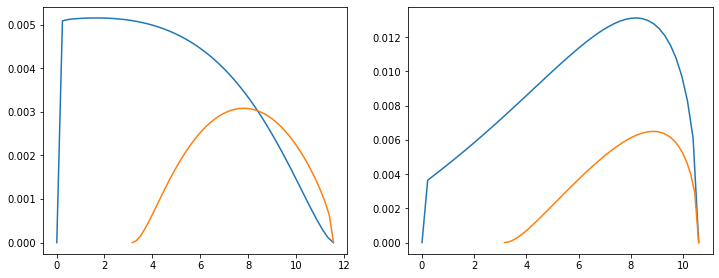

In [3]:
q2_mu = np.linspace(0.105**2, 11.5532)
q2_tau = np.linspace(1.778**2, 11.5532)
q2_star_mu = np.linspace(0.105**2, 10.595)
q2_star_tau = np.linspace(1.778**2, 10.595)

plt.figure(figsize=(12,10))
dGmu = dGammaDsmu(q2_mu)
dGtau = dGammaDstau(q2_tau)
dGstarmu = dGammaDsstarmu(q2_star_mu)
dGstartau = dGammaDsstartau(q2_star_tau)

ax1 = plt.subplot(221)
ax1.plot(q2_mu, dGmu)
ax1.plot(q2_tau, dGtau)

ax2 = plt.subplot(222)
ax2.plot(q2_star_mu, dGstarmu)
ax2.plot(q2_star_tau, dGstartau)

## Loading Data

In [4]:
epsilon_pimu = 1/100


# modes_dt = {0: {'mode': './features/DsTauNu_10Noise.root', 'yields': 4.97e5}, 
#             1: {'mode': './features/DsMuNu_10Noise.root', 'yields': 8.68e6},
#             2: {'mode': './features/DsstarTauNu_10Noise.root', 'yields': 7.90e5}, 
#             3: {'mode': './features/DsstarMuNu_10Noise.root', 'yields': 1.84e7},
#             4: {'mode': './features/RDsInclusive_10Noise.root', 'yields': 2.72e6},
#             5: {'mode': './features/RDsCombCascade_10Noise.root', 'yields': 8.72e6},
#             6: {'mode': './features/RDsMisID_10Noise.root', 'yields': epsilon_pimu*8.50e7}
#            }

# # 20noise
modes_dt = {0: {'mode': './features/DsTauNu_20Noise.root', 'yields': 4.93e5}, 
            1: {'mode': './features/DsMuNu_20Noise.root', 'yields': 8.55e6},
            2: {'mode': './features/DsstarTauNu_20Noise.root', 'yields': 7.86e5}, 
            3: {'mode': './features/DsstarMuNu_20Noise.root', 'yields': 1.82e7},
            4: {'mode': './features/RDsInclusive_20Noise.root', 'yields': 2.70e6},
            5: {'mode': './features/RDsCombCascade_20Noise.root', 'yields': 1.01e7},
            6: {'mode': './features/RDsMisID_20Noise.root', 'yields': epsilon_pimu*1.03e8}
           }

In [5]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        print('\rReading:', i)
        file = uproot.open(v['mode'])
#         df_i = file['t'].pandas.df()
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        
        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
#         print(len(idx))
        num_lt.append(len(idx))    

        df_i['target'] = i    # add the target label
        df_i['weight'] = v['yields']/len(idx)
        print(df_i['weight'][0])
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [6]:
tr_te_split = 0.5
df_train, df_test = load_train_test(modes_dt, tr_te_split)
# df_test, df_train = load_train_test(modes_dt, tr_te_split)
# make a copy
df_train_o, df_test_o = df_train.copy(), df_test.copy()

Reading: 0
317.45009658725047
Reading: 1
845.1957295373666
Reading: 2
934.6016646848989
Reading: 3
6862.745098039216
Reading: 4
1146.0101867572157
Reading: 5
1149.6869664200342
Reading: 6
11.46788990825688
train size: 58061 (50.00%); test size: 58058 (50.00%)
data points per mode:  [1553, 10116, 841, 2652, 2356, 8785, 89816]


In [7]:
def relabel(x):
    if x == 0 :    # Ds tau signal
        return 0
    elif x == 1:     # Ds mu signal
        return 1
    if x == 2 :    # Ds* tau signal
        return 2
    elif x == 3:     # Ds* mu signal
        return 3
    else:         # Bkg.
        return 4
    

In [8]:
# relabel the, all bkg become one label
df_train['target'] = df_train['target'].apply(relabel)
df_test['target'] = df_test['target'].apply(relabel)

In [9]:
df_train.columns

Index(['iEvt', 'q2', 'miss2', 'pB', 'EB', 'pHc', 'EHc', 'pMu', 'EMu',
       'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 'mHcMu',
       'pPerp', 'mCorr', 'D0Max', 'DzMax', 'D0Sum', 'DzSum', 'ENeutral03',
       'ENeutral06', 'ENeutral03Hadron', 'ENeutral06Hadron',
       'ENeutral03Photon', 'ENeutral06Photon', 'ECharge03', 'ECharge06',
       'ECharge03PV', 'ECharge06PV', 'ECharge03DV', 'ECharge06DV', 'mK0SHcMu',
       'pK0S', 'DeltaM', 'q2True', 'miss2True', 'EBTrue', 'pBTrue',
       'sMinMuHcVertTrue', 'correctPhoton', 'EPhoTrue', 'isDsPho',
       'DeltaRDsPhoTrue', 'target', 'weight'],
      dtype='object')

In [10]:
# features = ['q2', 'miss2', 
#             'pB', 'EB', 
#             'pHc', 'EHc', 
#             'pMu', 'EMu',
#             'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 
#             'mHcMu',
#             'pPerp', 'mCorr', 
#             'D0Max', 'DzMax', 'D0Sum', 'DzSum', 
#             'ENeutral03','ENeutral06', 
#             'ENeutral03Hadron', 'ENeutral06Hadron',
#             'ENeutral03Photon', 'ENeutral06Photon', 
#             'ECharge03', 'ECharge06',
#             'ECharge03PV', 'ECharge06PV', 
#             'ECharge03DV', 'ECharge06DV', 
#             'mK0SHcMu', 'pK0S', 
#             'DeltaM'
#            ]

features = ['q2', 'miss2', 
            'pB', 'EB', 
            'pHc', 'EHc', 
            'pMu', 'EMu',
            'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 
            'mHcMu',
            'pPerp', 'mCorr', 
            'D0Max', 'DzMax', 'D0Sum', 'DzSum', 
            'ENeutral03','ENeutral06', 
            'ENeutral03Hadron', 'ENeutral06Hadron',
            'ENeutral03Photon', 'ENeutral06Photon', 
            'ECharge03', 'ECharge06',
            'ECharge03PV', 'ECharge06PV', 
            'ECharge03DV', 'ECharge06DV', 
            'DeltaM'
           ]

In [11]:
df_train[features] = df_train[features].replace([99999, -np.inf, np.inf], np.nan)
df_test[features] = df_test[features].replace([99999, -np.inf, np.inf], np.nan)

In [12]:
t = 7
df_train_o[df_train_o.target==t]['pPerp']

Series([], Name: pPerp, dtype: float32)

## Reweight by $q^2
$

In [13]:
df_train_o[df_train_o.target==2].q2True.max(), df_train_o[df_train_o.target==3].q2True.min()

(11.514875, 0.075047046)

In [14]:
# replace some values that have q2 larger than the max, by the max
df_train_o.loc[(df_train_o['q2True']>=10.595) & ((df_train_o.target==2) | (df_train_o.target==3)), 'q2True'] = 10.594
df_train.loc[(df_train['q2True']>=10.595) & ((df_train.target==2) | (df_train.target==3)), 'q2True'] = 10.594
df_test.loc[(df_test['q2True']>=10.595) & ((df_test.target==2) | (df_test.target==3)), 'q2True'] = 10.594

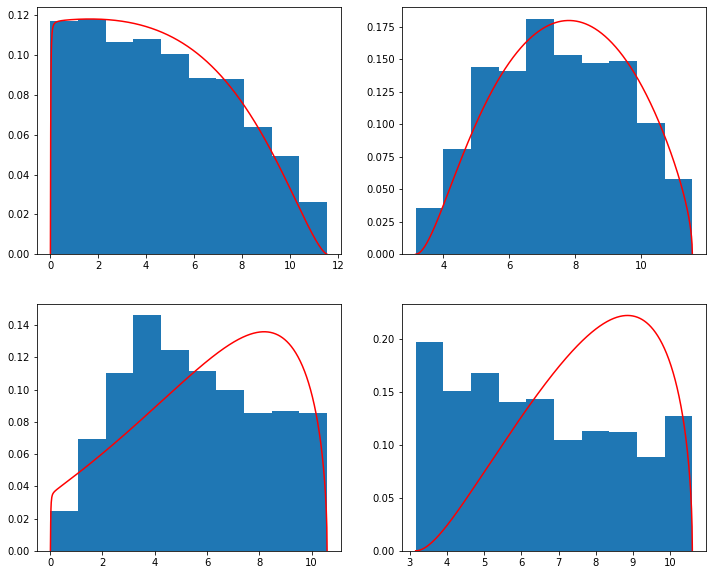

In [15]:
bins = 10

plt.figure(figsize=(12, 10))

# plot for mu
ax1 = plt.subplot(221)
range_mu = [0.105**2, 11.5532]
ax1.hist(df_train_o[df_train_o.target==1]['q2True'], bins=bins, density=True, range=range_mu);
q2_mu = np.linspace(range_mu[0], range_mu[1], 1000, endpoint=True)
dGmu = dGammaDsmu(q2_mu)
plt.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

# # plot for tau
ax2 = plt.subplot(222)
range_tau = [1.778**2, 11.5532]
bins=10
ax2.hist(df_train_o[df_train_o.target==0]['q2True'], bins=bins, density=True, range=range_tau);
q2_tau = np.linspace(range_tau[0], range_tau[1], 1000, endpoint=True)
dGtau = dGammaDstau(q2_tau)
plt.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

# plot for tau
ax3 = plt.subplot(223)
range_star_mu = [0.105**2, 10.594999]
ax3.hist(df_train_o[df_train_o.target==3]['q2True'], bins=bins, density=True, range=range_star_mu);
q2_star_mu = np.linspace(range_star_mu[0], range_star_mu[1], 1000, endpoint=True)
dGstarmu = dGammaDsstarmu(q2_star_mu)
plt.plot(q2_star_mu, dGstarmu/np.trapz(dGstarmu, x=q2_star_mu), color='red', label='theoretical')

# plot for mu
range_star_tau = [1.778**2, 10.594999]
ax4 = plt.subplot(224)
ax4.hist(df_train_o[df_train_o.target==3]['q2True'], bins=bins, density=True, range=range_star_tau);
q2_star_tau = np.linspace(range_star_tau[0], range_star_tau[1], 1000, endpoint=True)
dGstartau = dGammaDsstartau(q2_star_tau)
plt.plot(q2_star_tau, dGstartau/np.trapz(dGstartau, x=q2_star_tau), color='red', label='theoretical')

In [16]:
# reweight according to q^2
def find_m_rw(dGamma, df_train, target, range_, bin_num=10):
    # get the truth q2 array
    q2 = df_train[df_train.target==target]['q2True'].values    

    # Simulated bins
    hist, bins = np.histogram(a=q2, bins=bin_num, density=True, range=range_)
    width = np.diff(bins)
    center = (bins[:-1] + bins[1:]) / 2

    # Theoretical bins
    th_w = []
    for i in range(bin_num):
        dx = -(bins[i] - bins[i+1])/10
        x = np.linspace(bins[i], bins[i+1], 1000)
        y = dGamma(q2=x)
        th_w.append(np.trapz(y, dx=dx))    # Find area under curve
    # normalize
    th_w = th_w / sum(th_w) / width

    # reweighting
    m_rw = th_w / hist
    m_rw[np.isinf(m_rw)] = 0
    
    # return the values of each bin, and the bin bounds
    return m_rw, bins





# add the reweighting column to th dataframe
def add_m_rw(target, m_rw, bins, df):
    for i in range(len(bins)-1):
        df.loc[(df['target']==target) & (df['q2True']>=bins[i]) & (df['q2True']<bins[i+1]), 'm_rw'] = m_rw[i]
    
#     print(df.loc[df['target']==target, 'weight'].sum())
#     df.loc[df.target==target, 'm_rw'] = df.loc[df.target==target, 'm_rw']/(df.loc[df.target==target, 'm_rw'].sum())
    df.loc[df['target']==target, 'reweight'] = df.loc[df['target']==target, 'weight'] * df.loc[df.target==target, 'm_rw']
    df = df.drop(columns = ['m_rw'])
    
#     print(df.loc[df.target==target, 'reweight'].sum())
#     print()
    return df

In [17]:
# getting the weightings, and the bin bounds
m_rw_tau, bins_tau = find_m_rw(dGammaDstau, df_train_o, target=0, range_=range_tau)
m_rw_mu, bins_mu = find_m_rw(dGammaDsmu, df_train_o, target=1, range_=range_mu)
m_rw_star_tau, bins_star_tau = find_m_rw(dGammaDsstartau, df_train_o, target=2, range_=range_star_tau)
m_rw_star_mu, bins_star_mu = find_m_rw(dGammaDsstarmu, df_train_o, target=3, range_=range_star_mu)

# duplicate the column for inputting to the function to get the reweight column
df_train_o['reweight'] = df_train_o['weight']
df_train['reweight'] = df_train['weight']
df_test['reweight'] = df_test['weight']


df_train_o = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train_o)
df_train_o = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train_o)
df_train_o = add_m_rw(target=2, m_rw=m_rw_star_tau, bins=bins_star_tau, df=df_train_o)
df_train_o = add_m_rw(target=3, m_rw=m_rw_star_mu, bins=bins_star_mu, df=df_train_o)

df_train = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train)
df_train = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train)
df_train = add_m_rw(target=2, m_rw=m_rw_star_tau, bins=bins_star_tau, df=df_train)
df_train = add_m_rw(target=3, m_rw=m_rw_star_mu, bins=bins_star_mu, df=df_train)

df_test = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_test)
df_test = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_test)
df_test = add_m_rw(target=2, m_rw=m_rw_star_tau, bins=bins_star_tau, df=df_test)
df_test = add_m_rw(target=3, m_rw=m_rw_star_mu, bins=bins_star_mu, df=df_test)


In [18]:
m_rw_mu, m_rw_tau, m_rw_star_mu, m_rw_star_tau

(array([0.98347025, 0.99921598, 1.10114241, 1.05541184, 1.07579213,
        1.11191186, 0.9548824 , 0.99498055, 0.76100963, 0.38292772]),
 array([0.41338153, 0.80083369, 0.7929486 , 1.06461835, 0.94889895,
        1.16844554, 1.17270853, 1.01892799, 1.13513403, 0.984644  ]),
 array([1.64269332, 0.79669605, 0.62926636, 0.58014994, 0.80457356,
        1.03097589, 1.28361287, 1.58055237, 1.48940427, 1.00846833]),
 array([0.        , 1.05613053, 1.30948302, 1.05167022, 1.09968088,
        0.99077379, 0.97494769, 1.15290884, 1.15101707, 0.58802975]))

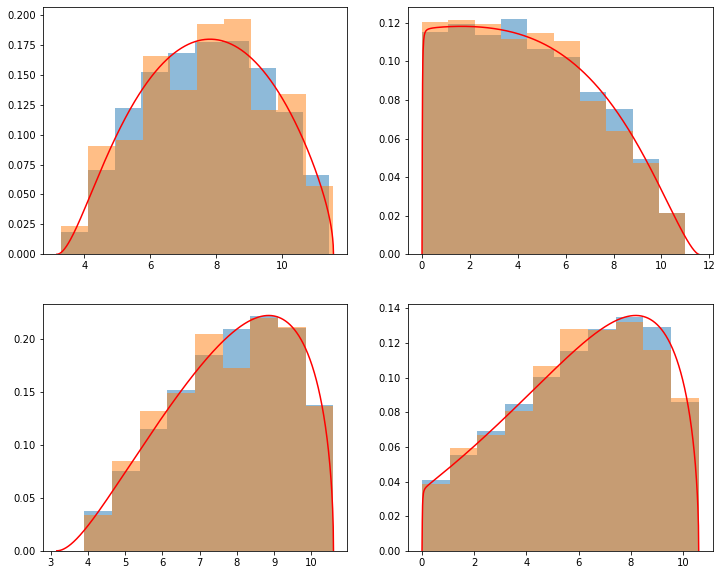

In [19]:
bins = 10

plt.figure(figsize=(12, 10))

# reweighted plot for tau, in testing 
ax1 = plt.subplot(221)
ax1.hist(df_train[df_train.target==0]['q2True'], bins=10, weights=df_train[df_train.target==0]['reweight'], density=True, alpha=0.5);
ax1.hist(df_test[df_test.target==0]['q2True'], bins=10, weights=df_test[df_test.target==0]['reweight'], density=True, alpha=0.5);
ax1.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

# reweighted plot for mu, in testing 
ax2 = plt.subplot(222)
ax2.hist(df_train[df_train.target==1]['q2True'], bins=10, weights=df_train[df_train.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.hist(df_test[df_test.target==1]['q2True'], bins=10, weights=df_test[df_test.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

ax3 = plt.subplot(223)
ax3.hist(df_train[df_train.target==2]['q2True'], bins=10, weights=df_train[df_train.target==2]['reweight'], density=True, alpha=0.5, range=range_star_tau);
ax3.hist(df_test[df_test.target==2]['q2True'], bins=10, weights=df_test[df_test.target==2]['reweight'], density=True, alpha=0.5, range=range_star_tau);
ax3.plot(q2_star_tau, dGstartau/np.trapz(dGstartau, x=q2_star_tau), color='red', label='theoretical')

ax4 = plt.subplot(224)
ax4.hist(df_train[df_train.target==3]['q2True'], bins=10, weights=df_train[df_train.target==3]['reweight'], density=True, alpha=0.5, range=range_star_mu);
ax4.hist(df_test[df_test.target==3]['q2True'], bins=10, weights=df_test[df_test.target==3]['reweight'], density=True, alpha=0.5, range=range_star_mu);
ax4.plot(q2_star_mu, dGstarmu/np.trapz(dGstarmu, x=q2_star_mu), color='red', label='theoretical')

## BDT

In [20]:
# getting the inputs and labels
X_train = df_train[features]
y_train = np.array(df_train.target)

# getting the inputs and labels
X_test = df_test[features]
y_test = np.array(df_train.target)

In [21]:
# trainging
X_train = df_train[features]
y_train = np.array([relabel(i) for i in df_train['target']])

# testing
X_test = df_test[features]
y_test = np.array([relabel(i) for i in df_test['target']])

# fitting, with reweighting
xgbc1 = xgb.XGBClassifier(seed=0)
xgbc1.fit(X_train, y_train, sample_weight=df_train.reweight.values);
# xgbc1.fit(X_train, y_train);

In [22]:
# transform the BDT output to score
def soft(prob, target):
    return np.exp(prob[:, target])/(np.exp(prob).sum(axis=1)) 

# scores for training
df_bdt_train_s = df_train[['target', 'reweight']]
df_bdt_train_s.loc[:, 'pred0'] = soft(xgbc1.predict_proba(X_train), 0)
df_bdt_train_s.loc[:, 'pred1'] = soft(xgbc1.predict_proba(X_train), 1)
df_bdt_train_s.loc[:, 'pred2'] = soft(xgbc1.predict_proba(X_train), 2)
df_bdt_train_s.loc[:, 'pred3'] = soft(xgbc1.predict_proba(X_train), 3)

# score for testing 
df_bdt_test_s = df_test[['target', 'reweight']]
df_bdt_test_s.loc[:, 'pred0'] = soft(xgbc1.predict_proba(X_test), 0)
df_bdt_test_s.loc[:, 'pred1'] = soft(xgbc1.predict_proba(X_test), 1)
df_bdt_test_s.loc[:, 'pred2'] = soft(xgbc1.predict_proba(X_test), 2)
df_bdt_test_s.loc[:, 'pred3'] = soft(xgbc1.predict_proba(X_test), 3)

## Finding the optimal position to cut

In [23]:
def bdt_cut(df, cut1, cut2, cut3, cut4, signal1=0, signal2=1, signal3=2, signal4=3):
    df1 = df[(df['pred0'] >= cut1) & (df['pred1'] < cut2) & (df['pred2'] < cut3) & (df['pred3'] < cut4)]    # pass tau cut, not pass mu cut
    df2 = df[(df['pred0'] < cut1) & (df['pred1'] >= cut2) & (df['pred2'] < cut3) & (df['pred3'] < cut4)]    # pass tau cut, not pass mu cut
    df3 = df[(df['pred0'] < cut1) & (df['pred1'] < cut2) & (df['pred2'] >= cut3) & (df['pred3'] < cut4)]    # pass tau cut, not pass mu cut
    df4 = df[(df['pred0'] < cut1) & (df['pred1'] < cut2) & (df['pred2'] < cut3) & (df['pred3'] >= cut4)]    # pass tau cut, not pass mu cut
    
    
    S1 = df1[df1['target'] == signal1]['reweight'].values.sum()    # Number of tau signals
    B1 = df1[df1['target'] != signal1]['reweight'].values.sum()    # Number of tau bkg.
#     B1 = df1[df1['target'] != signal1]['reweight'].values.sum() + df1[df1['target'] == 1]['reweight'].values.sum()*0.28/100   # Number of tau bkg.
    
    S2 = df2[df2['target'] == signal2]['reweight'].values.sum()    # Number of mu signals
    B2 = df2[df2['target'] != signal2]['reweight'].values.sum()    # Number of mu bkg.
#     B2 = df2[df2['target'] != signal2]['reweight'].values.sum() + df2[df2['target'] == 1]['reweight'].values.sum()*0.28/100   # Number of mu bkg.
        
    S3 = df3[df3['target'] == signal3]['reweight'].values.sum()    # Number of tau signals
    B3 = df3[df3['target'] != signal3]['reweight'].values.sum()    # Number of tau bkg.
#     B1 = df1[df1['target'] != signal1]['reweight'].values.sum() + df1[df1['target'] == 1]['reweight'].values.sum()*0.28/100   # Number of tau bkg.
    
    S4 = df4[df4['target'] == signal4]['reweight'].values.sum()    # Number of mu signals
    B4 = df4[df4['target'] != signal4]['reweight'].values.sum()    # Number of mu bkg.
#     B2 = df2[df2['target'] != signal2]['reweight'].values.sum() + df2[df2['target'] == 1]['reweight'].values.sum()*0.28/100   # Number of mu bkg.
    
    return ((S1+B1)**0.5, (0.1*B1), S1/(np.sqrt(S1+B1))), \
        ((S2+B2)**0.5, (0.1*B2), S2/(np.sqrt(S2+B2))), \
        ((S3+B3)**0.5, (0.1*B3), S3/(np.sqrt(S3+B3))), \
        ((S4+B4)**0.5, (0.1*B4), S4/(np.sqrt(S4+B4)))





# looping to find the optimal cut
def find_opt_cut(df_bdt_train_s, point1=None, point2=None, point3=None, point4=None, step=0.005):
    if (point1 is None and point2 is None and point3 is None and point4 is None):
        point1 = (round(df_bdt_train_s.min()['pred0'], 2), round(df_bdt_train_s.max()['pred0'], 2))
        point2 = (round(df_bdt_train_s.min()['pred1'], 2), round(df_bdt_train_s.max()['pred1'], 2))
        point3 = (round(df_bdt_train_s.min()['pred2'], 2), round(df_bdt_train_s.max()['pred2'], 2))
        point4 = (round(df_bdt_train_s.min()['pred3'], 2), round(df_bdt_train_s.max()['pred3'], 2))
       
    
    # tau cut
    print(point1[0] - step, point1[1] + step, step)
    cuts1 = np.arange(point1[0] - step, point1[1] + step, step)
    # mu cut
    cuts2 = np.arange(point2[0] - step, point2[1] + step, step)
    # tau cut
    cuts3 = np.arange(point3[0] - step, point3[1] + step, step)
    # mu cut
    cuts4 = np.arange(point4[0] - step, point4[1] + step, step)
    
    # store cuts (tau, and mu)
    c1_lt, c2_lt, c3_lt, c4_lt = [], [], [], []
    # store losses
    loss11, loss12 = [], []
    loss21, loss22 = [], []
    loss31, loss32 = [], []
    loss41, loss42 = [], []
    snr1, snr2, snr3, snr4 = [], [], [], []

    # loop over two cuts
    for i1, c1 in enumerate(cuts1):
        for i2, c2 in enumerate(cuts2):
            for i3, c3 in enumerate(cuts3):
                for i4, c4 in enumerate(cuts4):
                    print("{}/{}; {}/{}; {}/{}; {}/{}".format(i1, len(cuts1), i2, len(cuts2), i3, len(cuts3), i4, len(cuts4)), end='\r')
                    res1, res2, res3, res4 = bdt_cut(df_bdt_train_s, c1, c2, c3, c4)
                    c1_lt.append(c1); c2_lt.append(c2); c3_lt.append(c3); c4_lt.append(c4)

                    loss11.append(res1[0]); loss12.append(res1[1])
                    loss21.append(res2[0]); loss22.append(res2[1])
                    loss31.append(res3[0]); loss32.append(res3[1])
                    loss41.append(res4[0]); loss42.append(res4[1])
                    snr1.append(res1[2]), snr2.append(res2[2]), snr3.append(res3[2]), snr4.append(res4[2])

    # store the cuts and corresponding losses
    df_bdt_loss = pd.DataFrame([c1_lt, c2_lt, c3_lt, c4_lt, 
                                loss11, loss12, snr1, 
                                loss21, loss22, snr2, 
                                loss31, loss32, snr3, 
                                loss41, loss42, snr4]).T
    df_bdt_loss.columns = ['c1', 'c2', 'c3', 'c4', 
                           'loss11', 'loss12', 'snr1', 
                           'loss21', 'loss22', 'snr2', 
                           'loss31', 'loss32', 'snr3', 
                           'loss41', 'loss42', 'snr4']

    df_bdt_loss['loss1'] = (df_bdt_loss['loss11']**2 + df_bdt_loss['loss12']**2)**0.5
    df_bdt_loss['tot1'] = (df_bdt_loss['loss1'] - df_bdt_loss['loss1'].min())/(df_bdt_loss['loss1'].max() - df_bdt_loss['loss1'].min()) - \
        ((df_bdt_loss['snr1'] - df_bdt_loss['snr1'].min())/(df_bdt_loss['snr1'].max() - df_bdt_loss['snr1'].min()))

    df_bdt_loss['loss2'] = (df_bdt_loss['loss21']**2 + df_bdt_loss['loss22']**2)**0.5
    df_bdt_loss['tot2'] = (df_bdt_loss['loss2'] - df_bdt_loss['loss2'].min())/(df_bdt_loss['loss2'].max() - df_bdt_loss['loss2'].min()) - \
        ((df_bdt_loss['snr2'] - df_bdt_loss['snr2'].min())/(df_bdt_loss['snr2'].max() - df_bdt_loss['snr2'].min()))

    df_bdt_loss['loss3'] = (df_bdt_loss['loss31']**2 + df_bdt_loss['loss32']**2)**0.5
    df_bdt_loss['tot3'] = (df_bdt_loss['loss3'] - df_bdt_loss['loss3'].min())/(df_bdt_loss['loss3'].max() - df_bdt_loss['loss3'].min()) - \
        ((df_bdt_loss['snr3'] - df_bdt_loss['snr3'].min())/(df_bdt_loss['snr3'].max() - df_bdt_loss['snr3'].min()))

    df_bdt_loss['loss4'] = (df_bdt_loss['loss41']**2 + df_bdt_loss['loss42']**2)**0.5
    df_bdt_loss['tot4'] = (df_bdt_loss['loss4'] - df_bdt_loss['loss4'].min())/(df_bdt_loss['loss4'].max() - df_bdt_loss['loss4'].min()) - \
        ((df_bdt_loss['snr4'] - df_bdt_loss['snr4'].min())/(df_bdt_loss['snr4'].max() - df_bdt_loss['snr4'].min()))

    df_bdt_loss['tot'] = df_bdt_loss['tot1'] + df_bdt_loss['tot2'] + df_bdt_loss['tot3'] + df_bdt_loss['tot4']

    return df_bdt_loss.iloc[df_bdt_loss['tot'].argmin()][['c1', 'c2', 'c3', 'c4']].values

In [24]:
# %%time
# step = 0.005
# c1, c2, c3, c4 = find_opt_cut(df_bdt_train_s, step=step*5)
# c1, c2, c3, c4 = find_opt_cut(df_bdt_train_s, 
#                               (c1-step*3, c1+step*3), 
#                               (c2-step*3, c2+step*3), 
#                               (c3-step*3, c3+step*3), 
#                               (c4-step*3, c4+step*3), step)

# print(np.array([c1, c2, c3, c4]))


# 10 noise
c1, c2, c3, c4 = 0.25,  0.24,  0.295, 0.31

# 20 noise
# c1, c2, c3, c4 = 0.28,  0.25,  0.295, 0.3

In [25]:
# apply the cut, to select tau and mu samples
df_bdt_test_s0_cut = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] >= c1) & 
                                      (df_bdt_test_s['pred1'] <  c2) & 
                                      (df_bdt_test_s['pred2'] <  c3) & 
                                      (df_bdt_test_s['pred3'] <  c4)]

df_bdt_test_s1_cut = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] < c1) & 
                                      (df_bdt_test_s['pred1'] >=  c2) & 
                                      (df_bdt_test_s['pred2'] <  c3) & 
                                      (df_bdt_test_s['pred3'] <  c4)]

df_bdt_test_s2_cut = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] < c1) & 
                                      (df_bdt_test_s['pred1'] <  c2) & 
                                      (df_bdt_test_s['pred2'] >=  c3) & 
                                      (df_bdt_test_s['pred3'] <  c4)]

df_bdt_test_s3_cut = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] < c1) & 
                                      (df_bdt_test_s['pred1'] <  c2) & 
                                      (df_bdt_test_s['pred2'] <  c3) & 
                                      (df_bdt_test_s['pred3'] >=  c4)]


In [26]:
# Grouping the bkg. types
df_bdt_test_s0_cut['target'] = df_test_o.loc[df_bdt_test_s0_cut.index]['target']
df_bdt_test_s1_cut['target'] = df_test_o.loc[df_bdt_test_s1_cut.index]['target']
df_bdt_test_s2_cut['target'] = df_test_o.loc[df_bdt_test_s2_cut.index]['target']
df_bdt_test_s3_cut['target'] = df_test_o.loc[df_bdt_test_s3_cut.index]['target']

## Calculating the yields

In [27]:
def cal_uncertainty(df, channel, channel_labels):
    n_lt = []
    for i in channel_labels.keys():
        # Select the signal/bkg. 
        dfi = df[df.target==i]
        if len(dfi) == 0:
            ni = 0
        else: 
            # reweighted number 
            ni = dfi.reweight.sum() / (1-tr_te_split)
        # Print out the table
        if i==channel:
            print('(*Signal)  {}:\t\t{:.2e}'.format(channel_labels[i], ni))
#             print(len(dfi))
        else:
            print('(*Bkg.)    {}:\t\t{:.2e}'.format(channel_labels[i], ni))
#             print(len(dfi))
        
        n_lt.append(ni)
    # Estimate the Fake-Lambda_c Bkg.
#     n_fakeLambdac = n_lt[1]*0.28/100
#     n_lt.append(n_fakeLambdac)
#     print('(*Bkg.)  {}:\t{:.2e}'.format('Fake-Lambdac', n_fakeLambdac))
    
    
    print('.'*60)
    s = n_lt[channel]    # Number of signals
    b = sum(n_lt)    # Number of Bkg. (including the signals, since signal fluctaution also contribute to the uncertainty)
    Z = (2*((s + b)*np.log(1+s/b) - s))**0.5    #Signifiance
    u = 1/Z    # Uncertainty
    print("# of Siganl ({}):\t\t{:.2e}".format(channel_labels[channel], s))
    print("# of Bkg. for {}:\t\t{:.2e}".format(channel_labels[channel], (b-s)))
    print('Significance for {}:\t{:.0f}'.format(channel_labels[channel], Z))
    print('Uncertainty for {}:\t\t{:.5e} ({:.2e})'.format(channel_labels[channel], u, u))
    print('Uncertainty at {}:\t{:.5e} ({:.2e})'.format('10 TeraZ', 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5), 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)))
    print('S/B for {}:\t\t\t{:.2f}'.format(channel_labels[channel], s/(b-s)))
    print('\n'+'='*60+'\n'*1)
    print()

    u10 = 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)
    return u, u10, n_lt


In [28]:
CHANNEL_LABELS = {0: 'Ds tau', 1: 'Ds mu', 2: 'Ds* tau', 3: 'Ds* mu', 4: 'Inclusive', 5: 'Comb.+Casc.', 6: 'MisID',}
uFull_tau, uFull_tau10, n_lt_tau = cal_uncertainty(df_bdt_test_s0_cut, 0, CHANNEL_LABELS)
uFull_mu, uFull_mu10, n_lt_mu = cal_uncertainty(df_bdt_test_s1_cut, 1, CHANNEL_LABELS)


# print("Overall Uncertainty: {:.2e}".format((uFull_mu**2 + uFull_tau**2)**0.5))
# print("Overall Uncertainty 10-Tera Z: {:.2e}".format((uFull_mu10**2 + uFull_tau10**2)**0.5))
# print("\n"*5)


uFull_star_tau, uFull_star_tau10, n_lt_star_tau = cal_uncertainty(df_bdt_test_s2_cut, 2, CHANNEL_LABELS)
uFull_star_mu, uFull_star_mu10, n_lt_star_mu = cal_uncertainty(df_bdt_test_s3_cut, 3, CHANNEL_LABELS)


# print("Overall Uncertainty: {:.2e}".format((uFull_star_tau**2 + uFull_star_mu**2)**0.5))
# print("Overall Uncertainty 10-Tera Z: {:.2e}".format((uFull_star_tau10**2 + uFull_star_mu10**2)**0.5))

(*Signal)  Ds tau:		2.17e+05
(*Bkg.)    Ds mu:		4.17e+04
(*Bkg.)    Ds* tau:		8.53e+04
(*Bkg.)    Ds* mu:		6.48e+04
(*Bkg.)    Inclusive:		3.44e+04
(*Bkg.)    Comb.+Casc.:		5.95e+04
(*Bkg.)    MisID:		4.21e+03
............................................................
# of Siganl (Ds tau):		2.17e+05
# of Bkg. for Ds tau:		2.90e+05
Significance for Ds tau:	286
Uncertainty for Ds tau:		3.49443e-03 (3.49e-03)
Uncertainty at 10 TeraZ:	1.10503e-03 (1.11e-03)
S/B for Ds tau:			0.75



(*Bkg.)    Ds tau:		5.88e+04
(*Signal)  Ds mu:		7.25e+06
(*Bkg.)    Ds* tau:		2.81e+04
(*Bkg.)    Ds* mu:		4.81e+06
(*Bkg.)    Inclusive:		3.74e+05
(*Bkg.)    Comb.+Casc.:		1.42e+05
(*Bkg.)    MisID:		5.81e+04
............................................................
# of Siganl (Ds mu):		7.25e+06
# of Bkg. for Ds mu:		5.47e+06
Significance for Ds mu:	1874
Uncertainty for Ds mu:		5.33528e-04 (5.34e-04)
Uncertainty at 10 TeraZ:	1.68716e-04 (1.69e-04)
S/B for Ds mu:			1.32



(*Bkg.)    Ds tau:		1.48e+04
(*B

In [29]:
df_bdt_test_s0_cut['q2'] = df_test_o.loc[df_bdt_test_s0_cut.index]['q2']
df_bdt_test_s1_cut['q2'] = df_test_o.loc[df_bdt_test_s1_cut.index]['q2']
df_bdt_test_s2_cut['q2'] = df_test_o.loc[df_bdt_test_s2_cut.index]['q2']
df_bdt_test_s3_cut['q2'] = df_test_o.loc[df_bdt_test_s3_cut.index]['q2']

In [30]:
def binbybin_correction(df_train, cut):
    Cs = {}
    for i in np.unique(df_train.target):
        dfi = df_train[df_train.target == i]
        N_q2Low = dfi[dfi.q2 < cut]['reweight'].sum()
        N_q2High = dfi[dfi.q2 >= cut]['reweight'].sum()
        N_q2truthLow = dfi[dfi.q2True < cut]['reweight'].sum()
        N_q2truthHigh = dfi[dfi.q2True >= cut]['reweight'].sum()
        Cs[i] = [N_q2truthLow/N_q2Low, N_q2truthHigh/N_q2High]
    return Cs

In [31]:
df_train['target'] = df_train_o.loc[df_train.index]['target']

In [32]:
Cs = binbybin_correction(df_train, 7.15)
Cs[4] = [1, 1]
Cs[5] = [1, 1]
Cs[6] = [1, 1]
Cs

{0: [1.1094186716355934, 0.9386473040476931],
 1: [1.0005284643068706, 0.997993863492003],
 2: [1.1162383605652078, 0.9474209212532554],
 3: [0.958669514389567, 1.0690637561856446],
 4: [1, 1],
 5: [1, 1],
 6: [1, 1]}

In [33]:
def diff_measurement(df, q2_cut, Cs, channel):
    def _cal_uncertainty_(df, channel, channel_labels, Cs, region):
        n_lt = []
        for i in channel_labels.keys():
            # Select the signal/bkg. 
            dfi = df[df.target==i]
            if len(dfi) == 0:
                ni = 0
            else: 
                # reweighted number 
                ni = dfi.reweight.sum() / (1-tr_te_split) * Cs[i][region]
            # Print out the table
            if i==channel:
                print('(*Signal)  {}:\t{:.5e}'.format(channel_labels[i], ni))
            else:
                print('(*Bkg.)    {}:\t{:.5e}'.format(channel_labels[i], ni))

            n_lt.append(ni)
        # Estimate the Fake-J/psi Bkg.
#         n_fakeDs = n_lt[3]/26.23729
#         n_lt.append(n_fakeDs)
#         print('(*Bkg.)    {}:\t{:.5e}'.format('Fake-Ds', n_fakeDs))


        print('.'*40)
        s = n_lt[channel]    # Number of signals
        b = sum(n_lt)    # Number of Bkg. (including the signals, since signal fluctaution also contribute to the uncertainty)
        Z = (2*((s + b)*np.log(1+s/b) - s))**0.5    #Signifiance
        u = 1/Z    # Uncertainty
        print("# of Siganl ({}):     {:.5e}".format(channel_labels[channel], s))
        print("# of Bkg. for {}:     {:.5e}".format(channel_labels[channel], (b-s)))
        print('Significance for {}:  {:.0f}'.format(channel_labels[channel], Z))
        print('Uncertainty for {}:\t\t{:.5e} ({:.2e})'.format(channel_labels[channel], u, u))
        print('Uncertainty at {}:\t{:.5e} ({:.2e})'.format('10 TeraZ', 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5), 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)))
        print('S/B for {}:\t\t\t{:.2f}'.format(channel_labels[channel], s/(b-s)))
        print(s, (b-s))
        print('\n'+'='*40)

        return u, n_lt
    
    
    dfLow = df[df.q2 < q2_cut]
    dfHigh = df[df.q2 >= q2_cut]
    
    print('#####   q^2 < 7.15   #####')
    print()
    u_Low, n_lt_low = _cal_uncertainty_(dfLow, channel, CHANNEL_LABELS, Cs, 0)
    print()
    print('#####   q^2 >= 7.15   #####')    
    print()
    u_High, n_lt_high = _cal_uncertainty_(dfHigh, channel, CHANNEL_LABELS, Cs, 1)
    
    return u_Low, u_High, n_lt_low, n_lt_high
    

In [34]:
uLow0, uHigh0, n_lt_low0, n_lt_high0 = diff_measurement(df_bdt_test_s0_cut, 7.15, Cs, 0)

#####   q^2 < 7.15   #####

(*Signal)  Ds tau:	5.27630e+04
(*Bkg.)    Ds mu:	2.84095e+04
(*Bkg.)    Ds* tau:	1.58946e+04
(*Bkg.)    Ds* mu:	2.09432e+04
(*Bkg.)    Inclusive:	1.60404e+04
(*Bkg.)    Comb.+Casc.:	2.74538e+04
(*Bkg.)    MisID:	1.41932e+03
........................................
# of Siganl (Ds tau):     5.27630e+04
# of Bkg. for Ds tau:     1.10161e+05
Significance for Ds tau:  124
Uncertainty for Ds tau:		8.03385e-03 (8.03e-03)
Uncertainty at 10 TeraZ:	2.54053e-03 (2.54e-03)
S/B for Ds tau:			0.48
52763.02627860518 110160.82587441916


#####   q^2 >= 7.15   #####

(*Signal)  Ds tau:	1.59023e+05
(*Bkg.)    Ds mu:	1.32607e+04
(*Bkg.)    Ds* tau:	6.73421e+04
(*Bkg.)    Ds* mu:	4.59660e+04
(*Bkg.)    Inclusive:	1.83319e+04
(*Bkg.)    Comb.+Casc.:	3.20294e+04
(*Bkg.)    MisID:	2.79285e+03
........................................
# of Siganl (Ds tau):     1.59023e+05
# of Bkg. for Ds tau:     1.79723e+05
Significance for Ds tau:  255
Uncertainty for Ds tau:		3.91864e-03 (3.92e

In [35]:
uLow1, uHigh1, n_lt_low1, n_lt_high1 = diff_measurement(df_bdt_test_s1_cut, 7.15, Cs, 1)

#####   q^2 < 7.15   #####

(*Bkg.)    Ds tau:	4.68630e+04
(*Signal)  Ds mu:	5.84769e+06
(*Bkg.)    Ds* tau:	1.70390e+04
(*Bkg.)    Ds* mu:	2.99018e+06
(*Bkg.)    Inclusive:	2.56647e+05
(*Bkg.)    Comb.+Casc.:	1.28118e+05
(*Bkg.)    MisID:	5.26979e+04
........................................
# of Siganl (Ds mu):     5.84769e+06
# of Bkg. for Ds mu:     3.49155e+06
Significance for Ds mu:  1753
Uncertainty for Ds mu:		5.70479e-04 (5.70e-04)
Uncertainty at 10 TeraZ:	1.80401e-04 (1.80e-04)
S/B for Ds mu:			1.67
5847685.12919848 3491546.9298095237


#####   q^2 >= 7.15   #####

(*Bkg.)    Ds tau:	1.55647e+04
(*Signal)  Ds mu:	1.39997e+06
(*Bkg.)    Ds* tau:	1.21226e+04
(*Bkg.)    Ds* mu:	1.80897e+06
(*Bkg.)    Inclusive:	1.16866e+05
(*Bkg.)    Comb.+Casc.:	1.37269e+04
(*Bkg.)    MisID:	5.35678e+03
........................................
# of Siganl (Ds mu):     1.39997e+06
# of Bkg. for Ds mu:     1.97261e+06
Significance for Ds mu:  717
Uncertainty for Ds mu:		1.39462e-03 (1.39e-03)
Unce

In [36]:
uLow2, uHigh2, n_lt_low2, n_lt_high2 = diff_measurement(df_bdt_test_s2_cut, 7.15, Cs, 2)

#####   q^2 < 7.15   #####

(*Bkg.)    Ds tau:	1.98513e+03
(*Bkg.)    Ds mu:	0.00000e+00
(*Signal)  Ds* tau:	2.02431e+04
(*Bkg.)    Ds* mu:	0.00000e+00
(*Bkg.)    Inclusive:	2.29149e+03
(*Bkg.)    Comb.+Casc.:	4.57563e+03
(*Bkg.)    MisID:	2.51815e+02
........................................
# of Siganl (Ds* tau):     2.02431e+04
# of Bkg. for Ds* tau:     9.10407e+03
Significance for Ds* tau:  107
Uncertainty for Ds* tau:		9.30735e-03 (9.31e-03)
Uncertainty at 10 TeraZ:	2.94324e-03 (2.94e-03)
S/B for Ds* tau:			2.22
20243.101906562686 9104.066201949929


#####   q^2 >= 7.15   #####

(*Bkg.)    Ds tau:	1.22531e+04
(*Bkg.)    Ds mu:	1.86482e+03
(*Signal)  Ds* tau:	1.30352e+05
(*Bkg.)    Ds* mu:	8.57310e+04
(*Bkg.)    Inclusive:	1.14575e+04
(*Bkg.)    Comb.+Casc.:	6.86344e+03
(*Bkg.)    MisID:	1.80849e+03
........................................
# of Siganl (Ds* tau):     1.30352e+05
# of Bkg. for Ds* tau:     1.19978e+05
Significance for Ds* tau:  242
Uncertainty for Ds* tau:		4.13635e-

In [37]:
uLow3, uHigh3, n_lt_low3, n_lt_high3 = diff_measurement(df_bdt_test_s3_cut, 7.15, Cs, 3)

#####   q^2 < 7.15   #####

(*Bkg.)    Ds tau:	3.76899e+03
(*Bkg.)    Ds mu:	3.38841e+05
(*Bkg.)    Ds* tau:	3.23104e+04
(*Signal)  Ds* mu:	5.49449e+06
(*Bkg.)    Inclusive:	1.74153e+05
(*Bkg.)    Comb.+Casc.:	4.80441e+04
(*Bkg.)    MisID:	1.00268e+04
........................................
# of Siganl (Ds* mu):     5.49449e+06
# of Bkg. for Ds* mu:     6.07144e+05
Significance for Ds* mu:  1976
Uncertainty for Ds* mu:		5.06169e-04 (5.06e-04)
Uncertainty at 10 TeraZ:	1.60065e-04 (1.60e-04)
S/B for Ds* mu:			9.05
5494486.867667512 607144.4504704811


#####   q^2 >= 7.15   #####

(*Bkg.)    Ds tau:	3.96275e+03
(*Bkg.)    Ds mu:	1.02657e+05
(*Bkg.)    Ds* tau:	1.90283e+04
(*Signal)  Ds* mu:	3.90614e+06
(*Bkg.)    Inclusive:	1.03117e+05
(*Bkg.)    Comb.+Casc.:	6.86344e+03
(*Bkg.)    MisID:	2.35790e+03
........................................
# of Siganl (Ds* mu):     3.90614e+06
# of Bkg. for Ds* mu:     2.37986e+05
Significance for Ds* mu:  1697
Uncertainty for Ds* mu:		5.89390e-04 (5.89

In [41]:
RDs_ = 0.392931
RDsLow = 0.196073
RDsHigh = 1.15284

RDsstar_ = 0.302752
RDsstarLow = 0.170282
RDsstarHigh = 0.495824

In [42]:
def asy_form(s, b):
    return (2*((s+b)*np.log(1+s/b)-s))**0.5

def rss(a, b):
    return (a**2 + b**2)**0.5


In [43]:
def getCorr(n_lt_tau, n_lt_star_tau, RDs, RDsstar, percentage=0.005):

    x = n_lt_tau[0]
    bx = sum(n_lt_tau) - x
    y = n_lt_star_tau[2]
    by = sum(n_lt_star_tau) - y

    eps_y = n_lt_tau[2] / y
    eps_x = n_lt_star_tau[0] / x

    bx_other = bx - y*eps_y
    by_other = by - x*eps_x

    print('x: {:.5e}\t bx: {:.5e}\t {:.5e}'.format(x, bx, eps_y*y))
    print('y: {:.5e}\t by: {:.5e}\t {:.5e}'.format(y, by, eps_x*x))
    
    
#     ====================================================================

    plt.figure(figsize=(8,8))

    f = []

    x_min = x-percentage*x
    x_max = x+percentage*x+0.00000001
    y_min = y-percentage*y
    y_max = y+percentage*y+0.00000001
    # y_min = y-percentage/1.5*y
    # y_max = y+percentage/1.5*y+0.0000001

    n_steps = 1000
    xran = np.linspace(x_min, x_max, n_steps)
    yran = np.linspace(y_min, y_max, n_steps)

    for xi in xran:
        fx = []
        for yi in yran:

            bx_tot = bx_other + x + eps_y*y
            by_tot = by_other + y + eps_x*x

            fx.append(rss(asy_form(bx_other + xi + eps_y*yi - bx_tot, bx_tot), asy_form(by_other + yi + eps_x*xi - by_tot, by_tot)))

        f.append(fx)

    f = np.array(f).T

    x_2d, y_2d = np.meshgrid(xran, yran)

    f[f>1] = 0
    
    ax1 = plt.subplot(221)
    ax1.contourf(x_2d*RDs/x, y_2d*RDsstar/y, f)
#     ax1.colorbar()
    ax1.axhline(RDsstar, color='yellow')
    ax1.axvline(RDs, color='yellow')
#     ax1.xlabel('number of Ds tau')
#     ==============================================================================
    f_ = f.copy()
#     f_ = []

    a = np.argmax(f_, axis=1)
    a[a==0] = 9999
    i_x_min, i_x_max = min(a), max(np.argmax(f_, axis=1))
#     x_min, x_max = xran[i_x_min], xran[i_x_max]

    b = np.argmax(f_, axis=0)
    b[b==0] = 9999
    i_y_min, i_y_max = min(b), max(np.argmax(f_, axis=0))
#     y_min, y_max = yran[i_y_min], yran[i_y_max]
    
    
    i_x_closest = min([n_steps/2 - i_x_min, i_x_max - n_steps/2])
    i_y_closest = min([n_steps/2 - i_y_min, i_y_max - n_steps/2])
    
    x_min, x_max = xran[int(n_steps/2 - i_x_closest)], xran[int(n_steps/2 + i_x_closest)]
    y_min, y_max = yran[int(n_steps/2 - i_y_closest)], yran[int(n_steps/2 + i_y_closest)]
    
    ax2 = plt.subplot(222)
    ax2.contourf(x_2d*RDs/x, y_2d*RDsstar/y, f_)
#     ax2.colorbar()

    ax2.axhline(y_min*RDsstar/y, color='yellow')
    ax2.axhline(y_max*RDsstar/y, color='yellow')
    ax2.axvline(x_min*RDs/x, color='yellow')
    ax2.axvline(x_max*RDs/x, color='yellow')

#     ax2.xlabel('R(Ds)')
#     ax2.ylabel('R(Ds*)');

# =========================================================================================
    f = []

    frac = 0.006
#     xran = np.linspace(x_min - (x_max-x_min)*frac, x_max + (x_max-x_min)*frac, 750)
#     yran = np.linspace(y_min - (y_max-y_min)*frac, y_max + (y_max-y_min)*frac, 750)


    xran = np.linspace(x_min - (x_max-x_min)*frac, x_max + (x_max-x_min)*frac, 1000)
    yran = np.linspace(y_min - (y_max-y_min)*frac, y_max + (y_max-y_min)*frac, 1000)


    
    for xi in xran:
        fx = []
        for yi in yran:

            bx_tot = bx_other + x + eps_y*y
            by_tot = by_other + y + eps_x*x 

            fx.append(rss(asy_form(bx_other + xi + eps_y*yi - bx_tot, bx_tot), asy_form(by_other + yi + eps_x*xi - by_tot, by_tot)))

        f.append(fx)

    f = np.array(f).T

    x_2d, y_2d = np.meshgrid(xran, yran)

    f[f>1] = 0
    
    ax3 = plt.subplot(223)
    ax3.contourf(x_2d*RDs/x, y_2d*RDsstar/y, f)

#     ===============================================================================
    f_ = f.copy()

    f_[f_>1] = 0
    a = np.argmax(f_, axis=1)
    a[a==0] = 9999
    i_x_min, i_x_max = min(a), max(np.argmax(f_, axis=1))
    x_min, x_max = xran[i_x_min], xran[i_x_max]

    b = np.argmax(f_, axis=0)
    b[b==0] = 9999
    i_y_min, i_y_max = min(b), max(np.argmax(f_, axis=0))
    y_min, y_max = yran[i_y_min], yran[i_y_max]
    
    ax4 = plt.subplot(223)
    ax4.contourf(x_2d*RDs/x, y_2d*RDsstar/y, f_)
    
    ax4.axhline(RDsstar, color='yellow')
    ax4.axvline(RDs, color='yellow')
    ax4.axhline(y_max*RDsstar/y, color='yellow')
    ax4.axvline(x_min*RDs/x, color='yellow')
#     ============================================================================================
    pho_y1 = yran[np.argmax(f_[:, i_x_min])]
    pho_y2 = yran[np.argmax(f_[:, i_x_max])]

    pho_x1 = xran[np.argmax(f_[i_y_max, :])]
    pho_x2 = xran[np.argmax(f_[i_y_min, :])]
    
    ax5 = plt.subplot(224)
    ax5.contourf(x_2d*RDs/x, y_2d*RDsstar/y, f_)
    

    # plt.axhline(y_min)
    ax5.axhline(y_max*RDsstar/y, color='yellow')

    for ii, z in enumerate(f_[:, int(f_.shape[0]/2)][::-1]):
        if z != 0:
            print(ii)
            break


    ax5.axhline(yran[-ii]*RDsstar/y, color='yellow')
    ax5.axvline(xran[int(f_.shape[0]/2)]*RDs/x, color='yellow')
    ax5.axhline(yran[int(f_.shape[1]/2)]*RDsstar/y, color='yellow')
#     ===================================================================================
    sigma_inner = (yran[np.argmax(f_[:, int(f_.shape[1]/2)])] - yran[int(f_.shape[1]/2)])*RDsstar/y
    sigma_i = (y_max - yran[int(f_.shape[1]/2)])*RDsstar/y

    rho_xy = (1-(sigma_inner/sigma_i)**2)**0.5 * -1
    
    sigma_Ds = x_max*RDs/x - RDs
    sigma_Dsstar = y_max*RDsstar/y - RDsstar
    
    plt.show()
    
    
    print('R(Ds):  {:.2e}'.format(sigma_Ds/RDs))
    print('R(Ds*): {:.2e}'.format(sigma_Dsstar/RDsstar))
    print('rho:    {:.2f}'.format(rho_xy))
    print('rho:    {:.5f}'.format(rho_xy))

In [44]:
500-63, 500-19

(437, 481)

x: 1.86488e+05	 bx: 2.87632e+05	 7.54145e+04
y: 1.41406e+05	 by: 2.08449e+05	 1.09408e+04
66


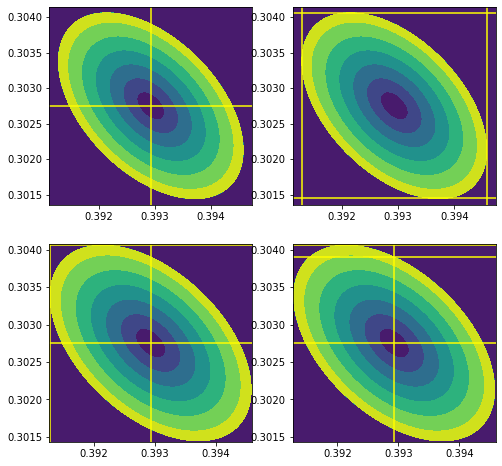

R(Ds):  4.18e-03
R(Ds*): 4.32e-03
rho:    -0.48
rho:    -0.47812
CPU times: user 10.1 s, sys: 110 ms, total: 10.2 s
Wall time: 10.2 s


In [45]:
%%time
# 10 noise
# getCorr(n_lt_tau, n_lt_star_tau, RDs_, RDsstar_, 0.00475)
# 20 noise
# getCorr(n_lt_tau, n_lt_star_tau, RDs_, RDsstar_, 0.006)
getCorr(n_lt_tau, n_lt_star_tau, RDs_, RDsstar_, 0.0046)

x: 2.16976e+06	 bx: 2.89911e+06	 8.53188e+05
y: 1.55721e+06	 by: 1.24153e+06	 1.48434e+05
63


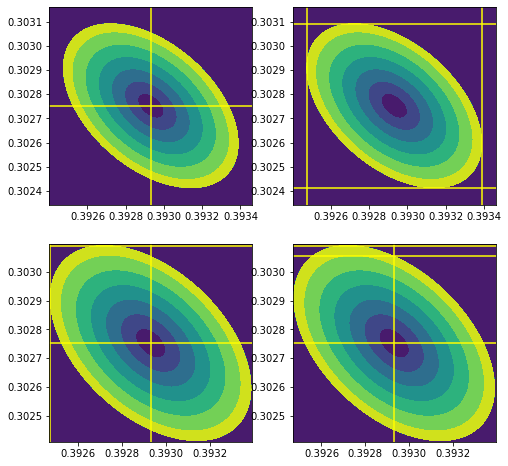

R(Ds):  1.16e-03
R(Ds*): 1.12e-03
rho:    -0.46
rho:    -0.46334


In [53]:
# 10 noise
getCorr([i*10 for i in n_lt_tau], [i*10 for i in n_lt_star_tau], RDs_, RDsstar_, 0.00135)


x: 5.27630e+04	 bx: 1.10161e+05	 1.58946e+04
y: 2.02431e+04	 by: 9.10407e+03	 1.98513e+03
47


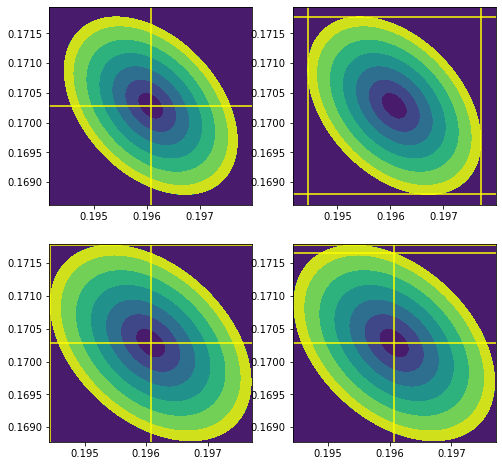

R(Ds):  8.30e-03
R(Ds*): 8.75e-03
rho:    -0.40
rho:    -0.39926


In [67]:
getCorr(n_lt_low0, n_lt_low2, RDsLow, RDsstarLow, 0.00975)

x: 5.27630e+05	 bx: 1.10161e+06	 1.58946e+05
y: 2.02431e+05	 by: 9.10407e+04	 1.98513e+04
47


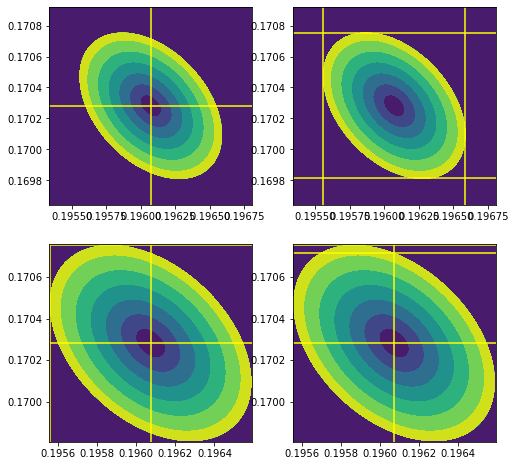

R(Ds):  2.62e-03
R(Ds*): 2.77e-03
rho:    -0.40
rho:    -0.39926


In [68]:
getCorr([i*10 for i in n_lt_low0], [i*10 for i in n_lt_low2], RDsLow, RDsstarLow, 0.00375)

x: 1.59023e+05	 bx: 1.79723e+05	 6.73421e+04
y: 1.30352e+05	 by: 1.19978e+05	 1.22531e+04
69


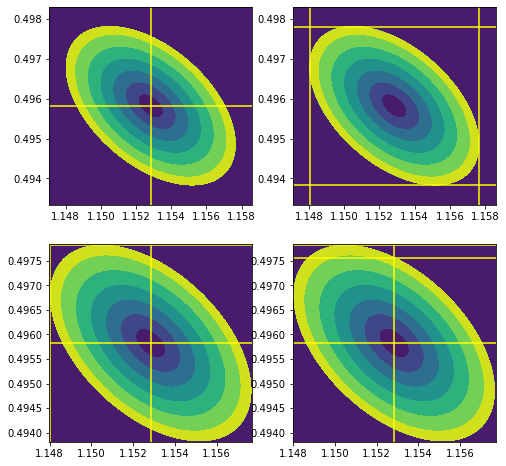

R(Ds):  4.17e-03
R(Ds*): 4.01e-03
rho:    -0.49
rho:    -0.48913


In [69]:
getCorr(n_lt_high0, n_lt_high2, RDsHigh, RDsstarHigh, 0.005)

x: 1.59023e+06	 bx: 1.79723e+06	 6.73421e+05
y: 1.30352e+06	 by: 1.19978e+06	 1.22531e+05
69


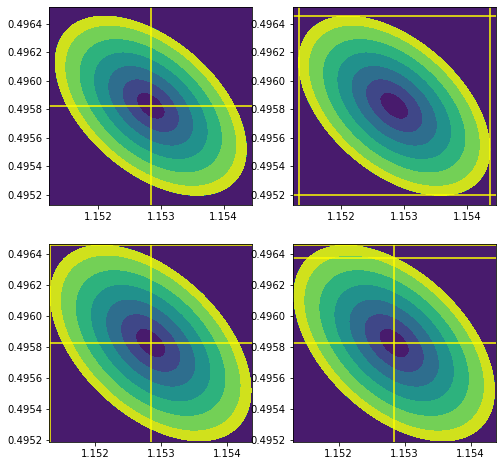

R(Ds):  1.32e-03
R(Ds*): 1.27e-03
rho:    -0.49
rho:    -0.48913


In [70]:
getCorr([i*10 for i in n_lt_high0], [i*10 for i in n_lt_high2], RDsHigh, RDsstarHigh, 0.0014)

## Saving Plots

In [21]:
df_plot = df_test

error for Ds tau mode: 2.17
error for Ds mu mode:  2.39
error for Ds* tau mode: 2.51
error for Ds* mu mode:  2.44


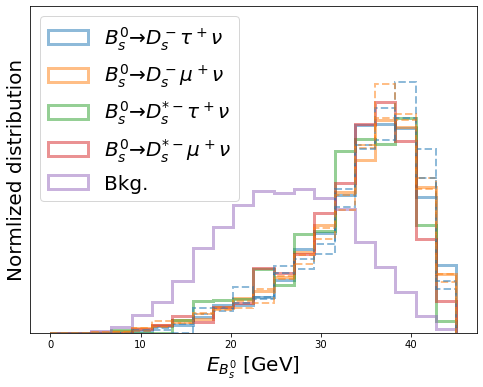

In [51]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,45]
bins_=20

ax1.margins(y=0.3)


ax1.hist(df_plot[(df_plot.target==0)]['EB'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['EB'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target==2)]['EB'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax1.hist(df_plot[(df_plot.target==3)]['EB'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['EB'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

ax1.legend(loc=2, fontsize=20)
ax1.hist(df_plot[(df_plot.target==0)]['EBTrue'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==1)]['EBTrue'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');
ax1.hist(df_plot[(df_plot.target==2)]['EBTrue'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==3)]['EBTrue'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$E_{B_s^0}$ [GeV]', fontsize=20)
ax1.set_yticks([])

X_mea0 = df_plot[(df_plot.target==0)]['EB']
X_mea1 = df_plot[(df_plot.target==1)]['EB']
X_mea2 = df_plot[(df_plot.target==2)]['EB']
X_mea3 = df_plot[(df_plot.target==3)]['EB']
X_tru0 = df_plot[(df_plot.target==0)]['EBTrue']
X_tru1 = df_plot[(df_plot.target==1)]['EBTrue']
X_tru2 = df_plot[(df_plot.target==2)]['EBTrue']
X_tru3 = df_plot[(df_plot.target==3)]['EBTrue']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1
X2 = X_mea2 - X_tru2
X3 = X_mea3 - X_tru3

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']
W2 = df_plot[(df_plot.target==2)]['reweight']
W3 = df_plot[(df_plot.target==3)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)
X_Wmean2 = sum(X2 * W2) / sum(W2)
X_Wmean3 = sum(X3 * W3) / sum(W3)

print("error for Ds tau mode: {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for Ds mu mode:  {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))
print("error for Ds* tau mode: {:.2f}".format((sum((X2 - X_Wmean2)**2 * W2) / (sum(W2)*(len(W2)-1)/len(W2)))**0.5))
print("error for Ds* mu mode:  {:.2f}".format((sum((X3 - X_Wmean3)**2 * W3) / (sum(W3)*(len(W3)-1)/len(W3)))**0.5))


f.savefig('./figures/DsEB')
# f.savefig('./figures/DsEB_20noise')



error for Ds tau mode: 1.52
error for Ds mu mode:  1.39
error for Ds* tau mode: 1.32
error for Ds* mu mode:  1.23


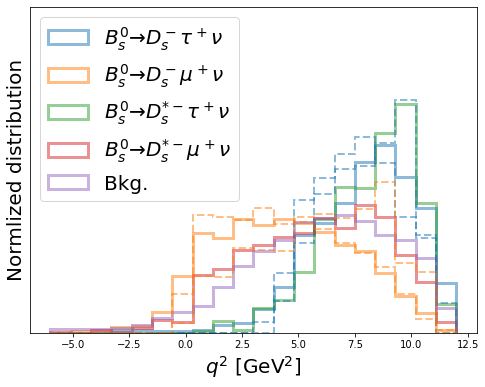

In [52]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-6,12]
bins_=20
ax1.margins(y=0.4)


ax1.hist(df_plot[(df_plot.target==0)]['q2'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['q2'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target==2)]['q2'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax1.hist(df_plot[(df_plot.target==3)]['q2'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['q2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

ax1.legend(loc=2, fontsize=20)
ax1.hist(df_plot[(df_plot.target==0)]['q2True'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==1)]['q2True'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');
ax1.hist(df_plot[(df_plot.target==2)]['q2True'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==3)]['q2True'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$q^2$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])


X_mea0 = df_plot[(df_plot.target==0)]['q2']
X_mea1 = df_plot[(df_plot.target==1)]['q2']
X_mea2 = df_plot[(df_plot.target==2)]['q2']
X_mea3 = df_plot[(df_plot.target==3)]['q2']
X_tru0 = df_plot[(df_plot.target==0)]['q2True']
X_tru1 = df_plot[(df_plot.target==1)]['q2True']
X_tru2 = df_plot[(df_plot.target==2)]['q2True']
X_tru3 = df_plot[(df_plot.target==3)]['q2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1
X2 = X_mea2 - X_tru2
X3 = X_mea3 - X_tru3

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']
W2 = df_plot[(df_plot.target==2)]['reweight']
W3 = df_plot[(df_plot.target==3)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)
X_Wmean2 = sum(X2 * W2) / sum(W2)
X_Wmean3 = sum(X3 * W3) / sum(W3)

print("error for Ds tau mode: {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for Ds mu mode:  {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))
print("error for Ds* tau mode: {:.2f}".format((sum((X2 - X_Wmean2)**2 * W2) / (sum(W2)*(len(W2)-1)/len(W2)))**0.5))
print("error for Ds* mu mode:  {:.2f}".format((sum((X3 - X_Wmean3)**2 * W3) / (sum(W3)*(len(W3)-1)/len(W3)))**0.5))

f.savefig('./figures/Dsq2')
# f.savefig('./figures/Dsq2_20noise')

error for Ds tau mode: 1.62
error for Ds mu mode:  1.81
error for Ds* tau mode: 1.32
error for Ds* mu mode:  1.48


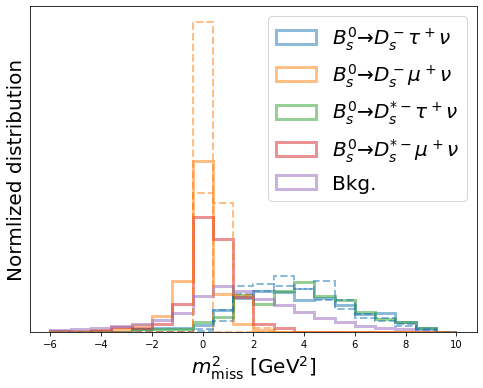

In [56]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-6,10]

# ax1.margins(y=0.3)


ax1.hist(df_plot[(df_plot.target==0)]['miss2'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['miss2'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target==2)]['miss2'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax1.hist(df_plot[(df_plot.target==3)]['miss2'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['miss2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

ax1.legend(loc=1, fontsize=20)
ax1.hist(df_plot[(df_plot.target==0)]['miss2True'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==1)]['miss2True'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');
ax1.hist(df_plot[(df_plot.target==2)]['miss2True'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==3)]['miss2True'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m_{\rm miss}^2$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])

X_mea0 = df_plot[(df_plot.target==0)]['miss2']
X_mea1 = df_plot[(df_plot.target==1)]['miss2']
X_mea2 = df_plot[(df_plot.target==2)]['miss2']
X_mea3 = df_plot[(df_plot.target==3)]['miss2']
X_tru0 = df_plot[(df_plot.target==0)]['miss2True']
X_tru1 = df_plot[(df_plot.target==1)]['miss2True']
X_tru2 = df_plot[(df_plot.target==2)]['miss2True']
X_tru3 = df_plot[(df_plot.target==3)]['miss2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1
X2 = X_mea2 - X_tru2
X3 = X_mea3 - X_tru3

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']
W2 = df_plot[(df_plot.target==2)]['reweight']
W3 = df_plot[(df_plot.target==3)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)
X_Wmean2 = sum(X2 * W2) / sum(W2)
X_Wmean3 = sum(X3 * W3) / sum(W3)

print("error for Ds tau mode: {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for Ds mu mode:  {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))
print("error for Ds* tau mode: {:.2f}".format((sum((X2 - X_Wmean2)**2 * W2) / (sum(W2)*(len(W2)-1)/len(W2)))**0.5))
print("error for Ds* mu mode:  {:.2f}".format((sum((X3 - X_Wmean3)**2 * W3) / (sum(W3)*(len(W3)-1)/len(W3)))**0.5))



f.savefig('./figures/Dsmiss2')
# f.savefig('./figures/Dsmiss2_20noise')


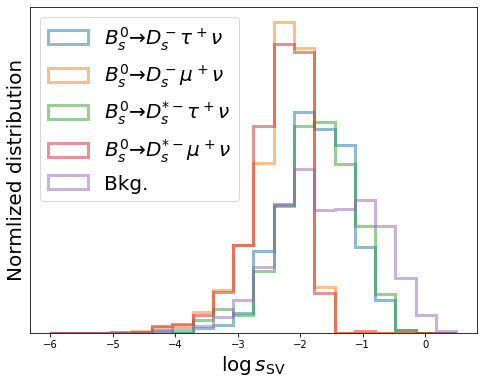

In [60]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-6,0.5]


ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuBVert']), weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuBVert']), weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==2)]['sMinMuBVert']), weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==3)]['sMinMuBVert']), weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['sMinMuBVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);

ax1.legend(loc=2, fontsize=20)
# ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, histtype='step', lw=3, alpha=0.5, color='C0', linestyle='--');
# ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, histtype='step', lw=3, alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\log{s_{\rm SV}}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=2, fontsize=20)

f.savefig('./figures/Dslogssv')
# f.savefig('./figures/Dslogssv_20noise')



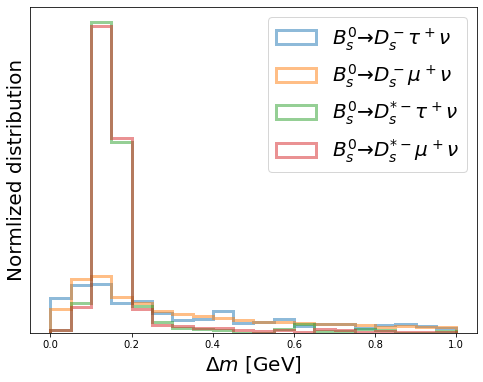

In [47]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,1]


ax1.hist(df_plot[(df_plot.target==0)]['DeltaM'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['DeltaM'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['DeltaM'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['DeltaM'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['DeltaM'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\Delta m$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/Dsdeltam')
# f.savefig('./figures/Dsdeltam_20noise')


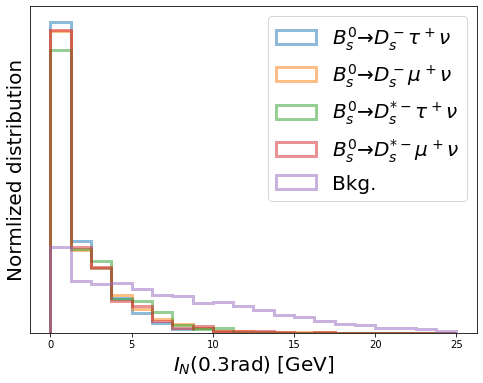

In [67]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,25]


ax1.hist(df_plot[(df_plot.target==0)]['ENeutral03'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['ENeutral03'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['ENeutral03'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['ENeutral03'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['ENeutral03'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$I_N(0.3\rm rad)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/Dsisolation')


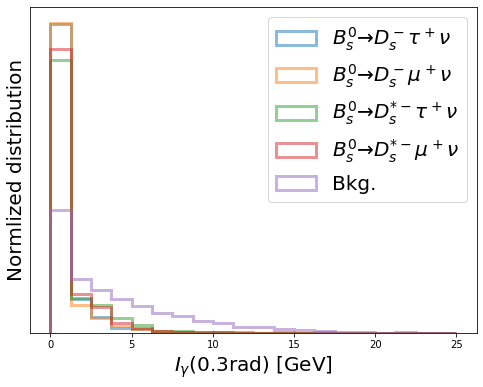

In [96]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,25]


ax1.hist(df_plot[(df_plot.target==0)]['ENeutral06Photon'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['ENeutral06Photon'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['ENeutral06Photon'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['ENeutral06Photon'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['ENeutral06Photon'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$I_\gamma(0.3\rm rad)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/Dsisolation_photon')


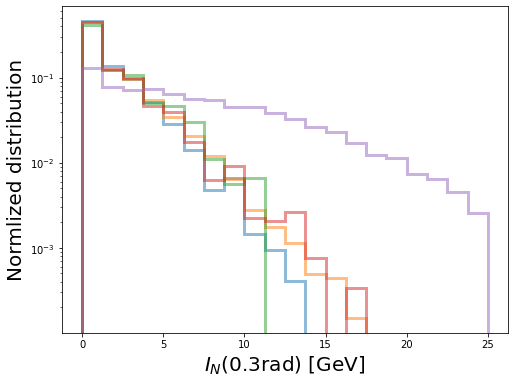

In [69]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,25]

# ax1.margins(y=0.3)

ax1.hist(df_plot[(df_plot.target==0)]['ENeutral03'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['ENeutral03'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['ENeutral03'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['ENeutral03'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['ENeutral03'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$I_N(0.3\rm rad)$ [GeV]', fontsize=20)
ax1.set_yticks([])
# ax1.legend(loc=1, fontsize=20)
ax1.set_yscale('log')

f.savefig('./figures/Dsisolation_logy')


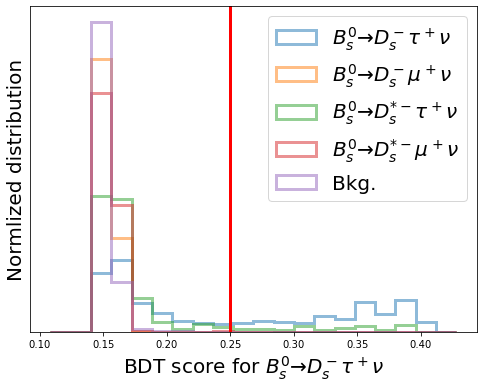

In [77]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
df_plot = df_bdt_test_s
pred0_max = df_plot[(df_plot.target==0)]['pred0'].max() 
pred0_min = df_plot[(df_plot.target==0)]['pred0'].min() 
pred0_diff = pred0_max - pred0_min
range_=[pred0_min - 0.1*pred0_max, pred0_max + 0.1*pred0_diff]

bins_=20
ax1.hist(df_plot[(df_plot.target==0)]['pred0'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['pred0'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['pred0'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['pred0'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pred0'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score for $B_s^0\to D_s^- \tau^+\nu$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.axvline(c1, color='red', lw=3)

f.savefig('./figures/DstauBDT')


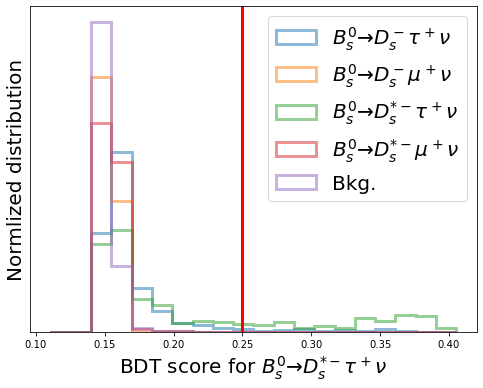

In [78]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
df_plot = df_bdt_test_s
pred0_max = df_plot[(df_plot.target==0)]['pred2'].max() 
pred0_min = df_plot[(df_plot.target==0)]['pred2'].min() 
pred0_diff = pred0_max - pred0_min
range_=[pred0_min - 0.1*pred0_max, pred0_max + 0.1*pred0_diff]

bins_=20
ax1.hist(df_plot[(df_plot.target==0)]['pred2'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['pred2'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['pred2'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['pred2'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pred2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score for $B_s^0\to D_s^{*-} \tau^+\nu$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.axvline(c1, color='red', lw=3)

f.savefig('./figures/DsstartauBDT')


error for Ds tau mode: 2.67
error for Ds mu mode:  2.67
error for Ds* tau mode: 2.30
error for Ds* mu mode:  3.14


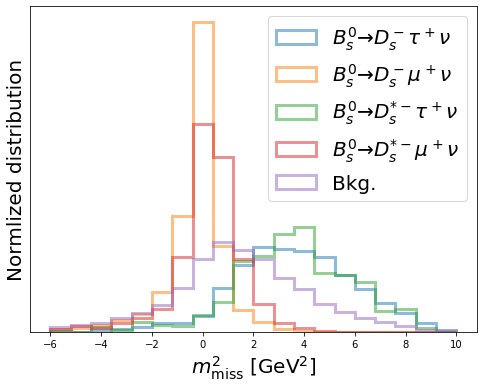

In [29]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-6,10]

# ax1.margins(y=0.3)
bins_=20

ax1.hist(df_plot[(df_plot.target==0)]['miss2'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['miss2'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target==2)]['miss2'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax1.hist(df_plot[(df_plot.target==3)]['miss2'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['miss2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

ax1.legend(loc=1, fontsize=20)
# ax1.hist(df_plot[(df_plot.target==0)]['miss2True'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==1)]['miss2True'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==2)]['miss2True'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==3)]['miss2True'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m_{\rm miss}^2$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])

X_mea0 = df_plot[(df_plot.target==0)]['miss2']
X_mea1 = df_plot[(df_plot.target==1)]['miss2']
X_mea2 = df_plot[(df_plot.target==2)]['miss2']
X_mea3 = df_plot[(df_plot.target==3)]['miss2']
X_tru0 = df_plot[(df_plot.target==0)]['miss2True']
X_tru1 = df_plot[(df_plot.target==1)]['miss2True']
X_tru2 = df_plot[(df_plot.target==2)]['miss2True']
X_tru3 = df_plot[(df_plot.target==3)]['miss2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1
X2 = X_mea2 - X_tru2
X3 = X_mea3 - X_tru3

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']
W2 = df_plot[(df_plot.target==2)]['reweight']
W3 = df_plot[(df_plot.target==3)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)
X_Wmean2 = sum(X2 * W2) / sum(W2)
X_Wmean3 = sum(X3 * W3) / sum(W3)

print("error for Ds tau mode: {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for Ds mu mode:  {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))
print("error for Ds* tau mode: {:.2f}".format((sum((X2 - X_Wmean2)**2 * W2) / (sum(W2)*(len(W2)-1)/len(W2)))**0.5))
print("error for Ds* mu mode:  {:.2f}".format((sum((X3 - X_Wmean3)**2 * W3) / (sum(W3)*(len(W3)-1)/len(W3)))**0.5))



# f.savefig('./figures/Dsmiss2')
f.savefig('./figures/Dsmiss2_20noise')


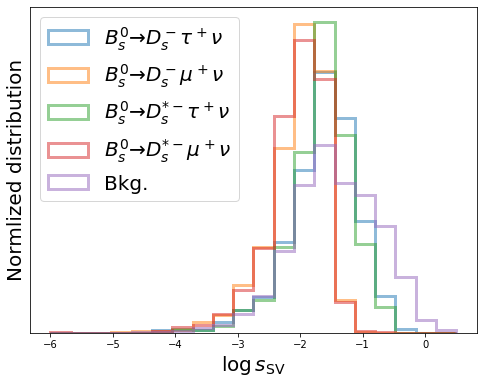

In [27]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-6,0.5]


ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuBVert']), weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuBVert']), weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==2)]['sMinMuBVert']), weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==3)]['sMinMuBVert']), weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['sMinMuBVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);

ax1.legend(loc=2, fontsize=20)
# ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, histtype='step', lw=3, alpha=0.5, color='C0', linestyle='--');
# ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, histtype='step', lw=3, alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\log{s_{\rm SV}}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=2, fontsize=20)

# f.savefig('./figures/Dslogssv')
f.savefig('./figures/Dslogssv_20noise')



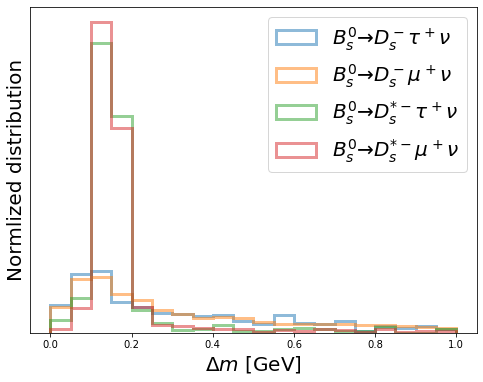

In [25]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,1]


ax1.hist(df_plot[(df_plot.target==0)]['DeltaM'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['DeltaM'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['DeltaM'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['DeltaM'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['DeltaM'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\Delta m$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

# f.savefig('./figures/Dsdeltam')
f.savefig('./figures/Dsdeltam_20noise')


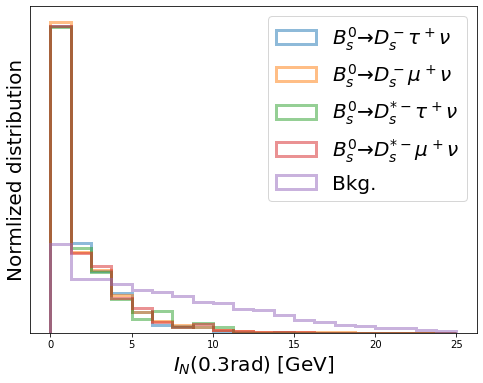

In [26]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,25]


ax1.hist(df_plot[(df_plot.target==0)]['ENeutral03'], weights=df_plot[df_plot.target==0]['reweight']/sum(df_plot[df_plot.target==0]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['ENeutral03'], weights=df_plot[df_plot.target==1]['reweight']/sum(df_plot[df_plot.target==1]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['ENeutral03'], weights=df_plot[df_plot.target==2]['reweight']/sum(df_plot[df_plot.target==2]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['ENeutral03'], weights=df_plot[df_plot.target==3]['reweight']/sum(df_plot[df_plot.target==3]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['ENeutral03'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']/sum(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight']), bins=20, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$I_N(0.3\rm rad)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

# f.savefig('./figures/Dsisolation')
f.savefig('./figures/Dsisolation_20noise')


In [63]:
df_plot0 = df_test.loc[df_bdt_test_s0_cut.index]
df_plot2 = df_test.loc[df_bdt_test_s2_cut.index]
# df_plot = df_test

[]

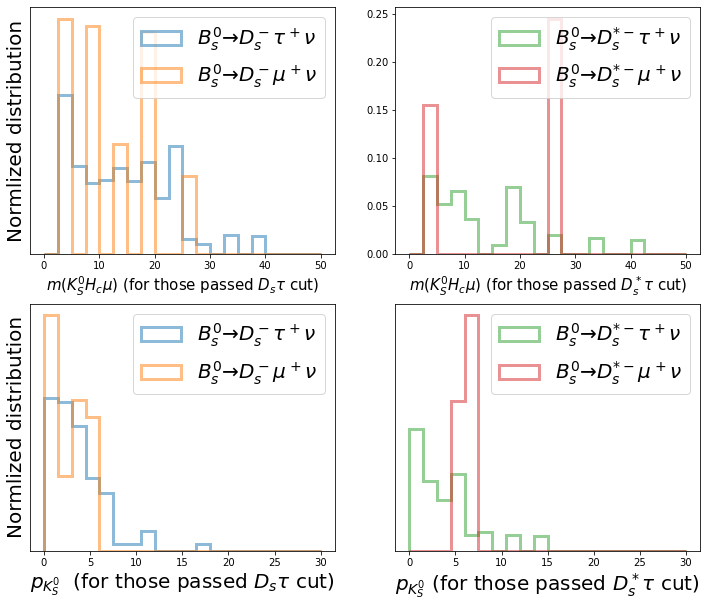

In [64]:
f = plt.figure(figsize=(12,10))
# ax1 = plt.subplot(111)
range_=[0, 50]

# ax1.margins(y=0.3)
bins_=20

# plt.
ax1 = plt.subplot(221)
ax1.hist(df_plot0[(df_plot0.target==0)]['mK0SHcMu'], weights=df_plot0[df_plot0.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_plot0[(df_plot0.target==1)]['mK0SHcMu'], weights=df_plot0[df_plot0.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');


ax2 = plt.subplot(222)
ax2.hist(df_plot2[(df_plot2.target==2)]['mK0SHcMu'], weights=df_plot2[df_plot2.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax2.hist(df_plot2[(df_plot2.target==3)]['mK0SHcMu'], weights=df_plot2[df_plot2.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pK0S'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');


ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m(K^0_S H_c \mu)$ (for those passed $D_s\tau$ cut)', fontsize=15)
ax2.set_xlabel(r'$m(K^0_S H_c \mu)$ (for those passed $D_s^* \tau$ cut)', fontsize=15)
ax1.set_yticks([])
ax3.set_yticks([])


range_=[0, 30]

ax3 = plt.subplot(223)
ax3.hist(df_plot0[(df_plot0.target==0)]['pK0S'], weights=df_plot0[df_plot0.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax3.hist(df_plot0[(df_plot0.target==1)]['pK0S'], weights=df_plot0[df_plot0.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');


ax4 = plt.subplot(224)
ax4.hist(df_plot2[(df_plot2.target==2)]['pK0S'], weights=df_plot2[df_plot2.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax4.hist(df_plot2[(df_plot2.target==3)]['pK0S'], weights=df_plot2[df_plot2.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pK0S'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

ax1.legend(loc=1, fontsize=20)
ax2.legend(loc=1, fontsize=20)
ax3.legend(loc=1, fontsize=20)
ax4.legend(loc=1, fontsize=20)

ax3.set_ylabel('Normlized distribution', fontsize=20)
ax3.set_xlabel(r'$p_{K^0_S}$  (for those passed $D_s\tau$ cut)', fontsize=20)
ax4.set_xlabel(r'$p_{K^0_S}$ (for those passed $D_s^*\tau$ cut)', fontsize=20)
ax3.set_yticks([])
ax4.set_yticks([])

# f.savefig('./Lambdab_plot/LambdabpK0S')
# f.savefig('./Lambdab_plot/LambdabpK0S_20noise')


In [65]:
print("fraction of events that contains reconstructed K0s:")
print("Ds tau:  {:.2f}\nDs mu:   {:.2f}\nDs* tau: {:.2f}\nDs* mu:  {:.2f}\n".format(
    1-len(df_test[(df_test.target==0) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==0)]),\
    1-len(df_test[(df_test.target==1) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==1)]),\
    1-len(df_test[(df_test.target==2) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==2)]),\
    1-len(df_test[(df_test.target==3) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==3)])))

fraction of events that contains reconstructed K0s:
Ds tau:  1.00
Ds mu:   1.00
Ds* tau: 1.00
Ds* mu:  1.00

